# 02. Neural Network classification with PyTorch

Versão em livro: https://www.learnpytorch.io/02_pytorch_classification/

## 1. Criando dados para classificação

Datasets de brinquedo (*toy datasets*) https://scikit-learn.org/stable/datasets/toy_dataset.html

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"Primeiros 5 de X:\n{X[:5]}")
print(f"Primeiros 5 de y:\n{y[:5]}")

Primeiros 5 de X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Primeiros 5 de y:
[1 1 1 1 0]


In [ ]:
# Montando um DataFrame com os dados
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


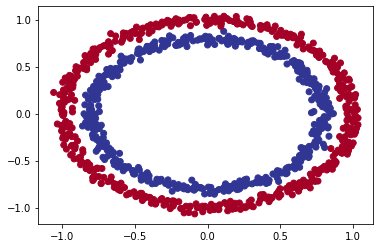

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

## 1.1 Checando shapes de input e output

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# Vendo o primeiro exemplo de features e labels
X_sample = X[0]
y_sample = y[0]

print(f"Valores para uma amostra de X: {X_sample} e o mesmo para y: {y_sample}")
print(f"Shapes para uma amostra de X: {X_sample.shape} e o mesmo para y: {y_sample.shape}")

Valores para uma amostra de X: [0.75424625 0.23148074] e o mesmo para y: 1
Shapes para uma amostra de X: (2,) e o mesmo para y: ()


### 1.2 Transformando os dados em tensores e criando os splits de treino e teste

In [ ]:
import torch
torch.__version__

'1.13.1+cu116'

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test)

(800, 200)

## 2. Construindo um modelo

Classificar os pontos azuis e vermelhos:

1. Definir código agnóstico a device
2. Construir um model (herdando de `nn.Module`)
3. Definir uma *loss function* e otimizador
4. Criar um loop de treino e de teste

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Para criar um modelo, devemos:

1. herdar de `nn.Module`, como quase todos os modelos em PyTorch.
2. Criar duas camadas `nn.Linear()` para serem capazes de tratar os shapes dos dados
3. Definir um método `forward()`
4. Criar uma instância da classe do modelo e enviar para o device alvo 

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5) # recebe 2 e aumenta para 5 números
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1) # Recebe 5 e prevê 1
    
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0
    

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Vamos replicar o modelo acima usando nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Poderíamos ter criado um atributo dentro de CircleModelV0 de uma instância desse Sequential e usá-lo no método `forward`

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.2147,  0.2980],
                      [-0.1476, -0.2197],
                      [-0.3801, -0.3453],
                      [-0.3900,  0.0212],
                      [ 0.1774, -0.6963]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4777, -0.3882,  0.1460, -0.3386,  0.5403], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4421, -0.1983, -0.3009, -0.1491,  0.4146]], device='cuda:0')),
             ('1.bias', tensor([0.3369], device='cuda:0'))])

In [ ]:
# Realizando predições com o estado atual aleatório do modelo
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length das predições: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length das amostras de teste: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nPrimeiras 10 predições:\n{untrained_preds[:10]}")
print(f"\nPrimeiros 10 labels:\n{y_test[:10]}")


Length das predições: 200, Shape: torch.Size([200, 1])
Length das amostras de teste: 200, Shape: torch.Size([200, 2])

Primeiras 10 predições:
tensor([[0.5283],
        [0.5963],
        [0.6824],
        [0.4832],
        [1.2101],
        [1.2475],
        [1.0208],
        [1.1747],
        [0.6599],
        [0.6067]], device='cuda:0')

Primeiros 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Definindo a loss function e o otimizador

Qual loss function ou otimizador devemos usar? Isso é específico para cada problema.

Por exemplo, para regressão, podemos querer MAE ou MSE. 

Para classificação podemos querer *Binary Cross Entropy* ou *Categorical Cross Entropy*. Usaremos `torch.nn.BCEWithLogitsLoss()`

Para os otimizadores, os mais famosos são SGD e Adam. Existem muitos outros.

Recursos: 

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean



In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Possui a função de ativação sigmoid
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [13]:
# Calculando acurácia
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Treinando o modelo

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Indo de logits -> probabilidades -> labels

Nosso modelo produz **logits**

 Podemos converter esses **logits** em probabilidades de predição ao passá-los por algum tipo de função de ativação (sigmoid para classificação binária ou softmax para multiclasse)

 Depois, poderemos converter essas probabilidades para labels ou arredondando ou usando `argmax()`.

In [ ]:
# Quais são os cinco primeiro logits de saída para os dados de teste?
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5283],
        [0.5963],
        [0.6824],
        [0.4832],
        [1.2101]], device='cuda:0')

In [ ]:
# Usando a função de ativação sigmoid em cima desses logits
# para torná-los em probabilidades
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs          

tensor([[0.6291],
        [0.6448],
        [0.6643],
        [0.6185],
        [0.7703]], device='cuda:0')

Para os valores de probabilidade, aplicamos a seguinte lógica:

* `y_pred_probs` >= 0.5, `y=1` (classe 1)
* `y_pred_probs` < 0.5, `y=0` (classe 0)



In [ ]:
# Encontrando os labels a partir das probabilidades
y_preds = torch.round(y_pred_probs)

# Tudo em uma linha
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


### 3.2 Construindo um loop de treino e de teste

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Temos que transformar os logits em classes
  # Já que queremos 0's e 1's
  y_train_logits = model_0(X_train).squeeze()
  y_train_preds = torch.round(torch.sigmoid(y_train_logits))

  # A nossa loss fn espera logits
  # nn.BCEWithLogitsLoss
  y_train_loss = loss_fn(y_train_logits, y_train)

  # Se a loss fn fosse a nn.BCELoss, teríamos que passar probs:
  # y_train_loss = loss_fn(torch.sigmoid(y_logits),
  #                         y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_train_preds)
  
  optimizer.zero_grad()

  y_train_loss.backward()

  optimizer.step()

  ### Teste
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Loss: {y_train_loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch 0 | Loss: 0.79275, Acc: 50.00% | Test Loss: 0.77583, Test acc: 50.00%
Epoch 10 | Loss: 0.72876, Acc: 50.00% | Test Loss: 0.72323, Test acc: 50.00%
Epoch 20 | Loss: 0.70723, Acc: 50.75% | Test Loss: 0.70592, Test acc: 51.50%
Epoch 30 | Loss: 0.69943, Acc: 54.87% | Test Loss: 0.69990, Test acc: 52.00%
Epoch 40 | Loss: 0.69644, Acc: 51.62% | Test Loss: 0.69775, Test acc: 52.50%
Epoch 50 | Loss: 0.69521, Acc: 51.50% | Test Loss: 0.69694, Test acc: 49.50%
Epoch 60 | Loss: 0.69466, Acc: 50.62% | Test Loss: 0.69660, Test acc: 51.50%
Epoch 70 | Loss: 0.69436, Acc: 50.50% | Test Loss: 0.69643, Test acc: 49.50%
Epoch 80 | Loss: 0.69418, Acc: 50.38% | Test Loss: 0.69632, Test acc: 49.50%
Epoch 90 | Loss: 0.69405, Acc: 50.12% | Test Loss: 0.69623, Test acc: 49.50%


## 4. Realizando predições e avaliando o modelo

Isso significa que o nosso modelo está basicamente chutando a classificação e não está aprendendo nada.

Vamos visualizar as predições utilizando de uma função importada de: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [45]:
import requests
from pathlib import Path

# Download de funções auxiliares de um repo se já não tiver sido

if Path("helper_functions.py").is_file():
    print("helper_functions.py já existe, pulando download")
else:
    print("Baixando helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
      f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Baixando helper_functions.py


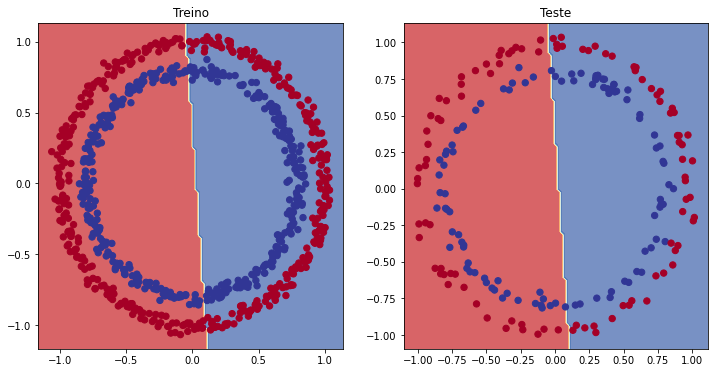

In [ ]:
# Plota os limites de decisão do modelo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Treino")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Teste")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Melhorando um modelo (da perspectiva de um modelo)

Podemos:

* Adicionar mais camadas - Dá ao modelo mais oportunidade de aprender padrões sobre os dados
* Adicionar mais nós por camada - Ir de 5 para 10 unidades por camada
* Treinar por mais tempo - Aumentar o número de épocas
* Mudar a função de ativação
* Mudar a taxa de aprendizado
* Mudar a função de perda (*loss function*)
* Mudar a função de otimização

Essas opções são todas da perspectiva do modelo pois ela lidam com o modelo diretamente e não com os dados.

Já que essas opções são todos valores que nós podemos mudar, elas são conhecidas como **hiperparâmetros**.

Vamos tentar melhorar o nosso modelo:

* Adicionando mais unidades por camada: 5 -> 10
* Adicionando mais camadas: 2-> 3
* Aumentando o número de épocas: 100 -> 1000

Geralmente, mudaríamos apenas um desses valores por vez (*experiment tracking*), mas mudaremos todos aqui.

In [ ]:
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 =  nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
  def forward(self, x):
    # z = self.layer_1(x) # z == logits
    # z = self.layer_1(z)
    # z = self.layer_3(z)
    # Essa forma de escrever abaixo leva a speedups onde possível
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  train_loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {acc:.5f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 51.00000% | Test Loss: 0.69261, Test acc: 49.00%
Epoch: 100 | Loss: 0.69305, Acc: 48.00000% | Test Loss: 0.69379, Test acc: 49.00%
Epoch: 200 | Loss: 0.69299, Acc: 46.00000% | Test Loss: 0.69437, Test acc: 49.00%
Epoch: 300 | Loss: 0.69298, Acc: 45.00000% | Test Loss: 0.69458, Test acc: 49.00%
Epoch: 400 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69465, Test acc: 49.00%
Epoch: 500 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69467, Test acc: 49.00%
Epoch: 600 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69468, Test acc: 49.00%
Epoch: 700 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69468, Test acc: 49.00%
Epoch: 800 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69468, Test acc: 49.00%
Epoch: 900 | Loss: 0.69298, Acc: 46.00000% | Test Loss: 0.69468, Test acc: 49.00%


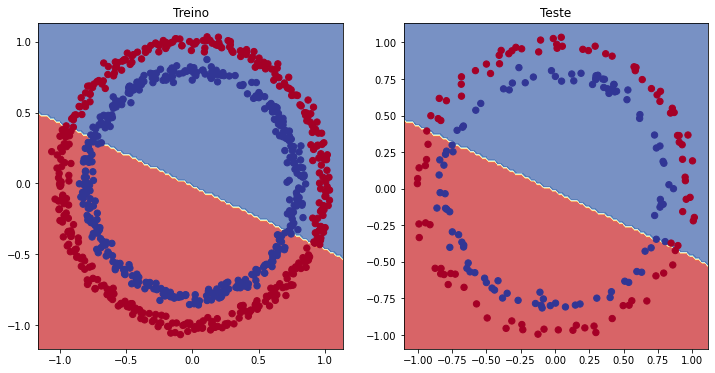

In [ ]:
# Plota os limites de decisão do modelo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Treino")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Teste")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparando dados para ver se o modelo pode fittar uma linha reta

Um jeito de resolver um problema maior é o modelo em um problema menor. 

In [ ]:
# Criando dados (o mesmo que notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Regressão linear

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression)

(80, 20)

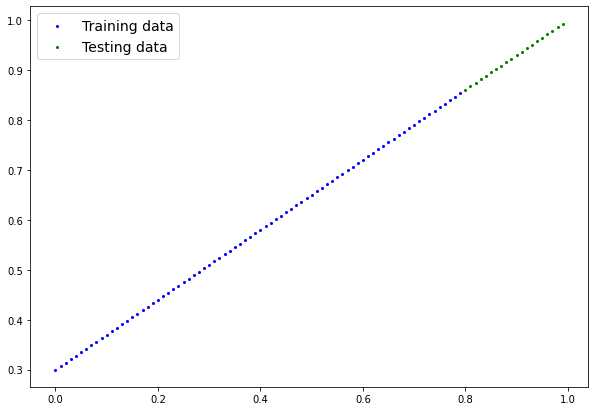

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Ajustando model_1 para fittar em uma linha reta

In [ ]:
# Mesma arquitetura que model_1 (mas usando nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss() # Agora é um problema de regressão
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.94965
Epoch: 100 | Loss: 0.40272 | Test loss: 0.54029
Epoch: 200 | Loss: 0.05876 | Test loss: 0.13480
Epoch: 300 | Loss: 0.01461 | Test loss: 0.03342
Epoch: 400 | Loss: 0.00308 | Test loss: 0.00008
Epoch: 500 | Loss: 0.00309 | Test loss: 0.00012
Epoch: 600 | Loss: 0.00309 | Test loss: 0.00018
Epoch: 700 | Loss: 0.00299 | Test loss: 0.00011
Epoch: 800 | Loss: 0.00299 | Test loss: 0.00016
Epoch: 900 | Loss: 0.00289 | Test loss: 0.00011


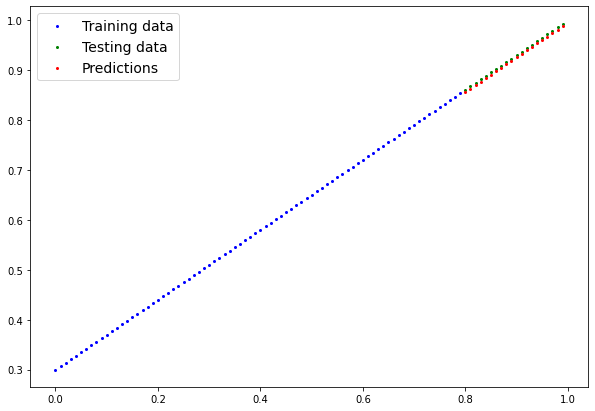

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

O modelo é capaz de aprender sim, mas não nos dados circulares (não-lineares)

## 6. A peça faltando: Não-linearidade

"Que padrões seriam possíveis desenhar se nos fosse dado uma quantidade infinita de linhas retas e não retas?"

Ou em termos de ML, uma quantidade infinita de funções lineares e não lineares.

### 6.1 Recriando os dados não lineares (círculos vermelhos e azuis)

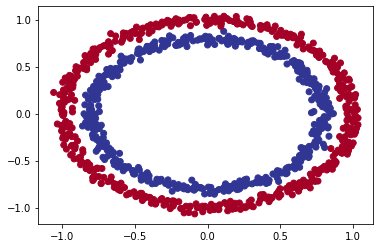

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convertendo dados para tensores e dividindo entre treino e teste
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Construindo um modelo com não-linearidade

Redes neurais artificiais são uma combinação de funções lineares e não-lineares que são potencialmente capazes de encontrar padrões em dados.

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu é uma função de ativação não-linear
  
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
# Treinando o modelo não-linear
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_preds_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_preds_logits))

  loss = loss_fn(y_preds_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_test).squeeze()
    y_test_labels = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)

  if epoch % 100 == 0 or epoch == epochs - 1:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")



Epoch: 0 | Loss: 0.6929, acc: 50.00 | Test Loss: 0.6932, Test acc: 50.00
Epoch: 100 | Loss: 0.6912, acc: 52.88 | Test Loss: 0.6910, Test acc: 52.50
Epoch: 200 | Loss: 0.6898, acc: 53.37 | Test Loss: 0.6894, Test acc: 55.00
Epoch: 300 | Loss: 0.6879, acc: 53.00 | Test Loss: 0.6872, Test acc: 56.00
Epoch: 400 | Loss: 0.6852, acc: 52.75 | Test Loss: 0.6841, Test acc: 56.50
Epoch: 500 | Loss: 0.6810, acc: 52.75 | Test Loss: 0.6794, Test acc: 56.50
Epoch: 600 | Loss: 0.6751, acc: 54.50 | Test Loss: 0.6729, Test acc: 56.00
Epoch: 700 | Loss: 0.6666, acc: 58.38 | Test Loss: 0.6632, Test acc: 59.00
Epoch: 800 | Loss: 0.6516, acc: 64.00 | Test Loss: 0.6476, Test acc: 67.50
Epoch: 900 | Loss: 0.6236, acc: 74.00 | Test Loss: 0.6215, Test acc: 79.00
Epoch: 999 | Loss: 0.5689, acc: 87.62 | Test Loss: 0.5744, Test acc: 86.50


### 6.4 Avaliando o modelo não-linear

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

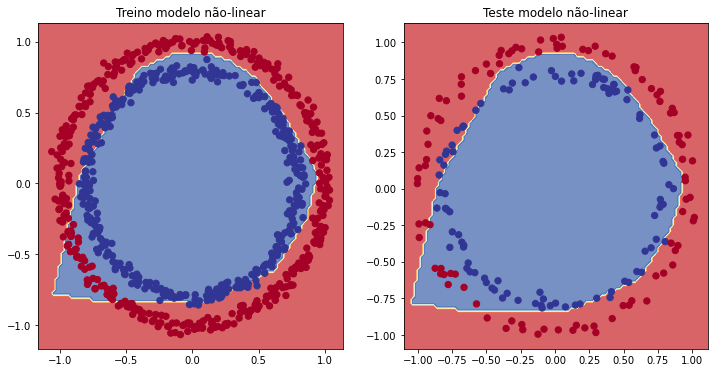

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Treino modelo não-linear")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Teste modelo não-linear")
plot_decision_boundary(model_3, X_test, y_test)

### Desafio: Tentando melhorar o modelo

De acordo com o que foi visto, podemos realizar algumas alterações no modelo para melhorar a sua performance.

No caso, vou aumentar o número de épocas para 1500.

In [ ]:
model_3_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_3_1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3_1.parameters(), lr=0.1)

In [ ]:
# Treinando o modelo não-linear
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3_1.train()

  y_preds_logits = model_3_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_preds_logits))

  loss = loss_fn(y_preds_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3_1.eval()
  with torch.inference_mode():
    y_test_logits = model_3_1(X_test).squeeze()
    y_test_labels = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)

  if epoch % 100 == 0 or epoch == epochs - 1:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.6929, acc: 50.00 | Test Loss: 0.6932, Test acc: 50.00
Epoch: 100 | Loss: 0.6912, acc: 52.88 | Test Loss: 0.6910, Test acc: 52.50
Epoch: 200 | Loss: 0.6898, acc: 53.37 | Test Loss: 0.6894, Test acc: 55.00
Epoch: 300 | Loss: 0.6879, acc: 53.00 | Test Loss: 0.6872, Test acc: 56.00
Epoch: 400 | Loss: 0.6852, acc: 52.75 | Test Loss: 0.6841, Test acc: 56.50
Epoch: 500 | Loss: 0.6810, acc: 52.75 | Test Loss: 0.6794, Test acc: 56.50
Epoch: 600 | Loss: 0.6751, acc: 54.50 | Test Loss: 0.6729, Test acc: 56.00
Epoch: 700 | Loss: 0.6666, acc: 58.38 | Test Loss: 0.6632, Test acc: 59.00
Epoch: 800 | Loss: 0.6516, acc: 64.00 | Test Loss: 0.6476, Test acc: 67.50
Epoch: 900 | Loss: 0.6236, acc: 74.00 | Test Loss: 0.6215, Test acc: 79.00
Epoch: 1000 | Loss: 0.5682, acc: 87.75 | Test Loss: 0.5738, Test acc: 86.50
Epoch: 1100 | Loss: 0.4815, acc: 93.50 | Test Loss: 0.4993, Test acc: 90.50
Epoch: 1200 | Loss: 0.3706, acc: 97.75 | Test Loss: 0.4059, Test acc: 92.00
Epoch: 1300 | Loss: 0.25

In [ ]:
model_3_1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3_1(X_test))).squeeze()

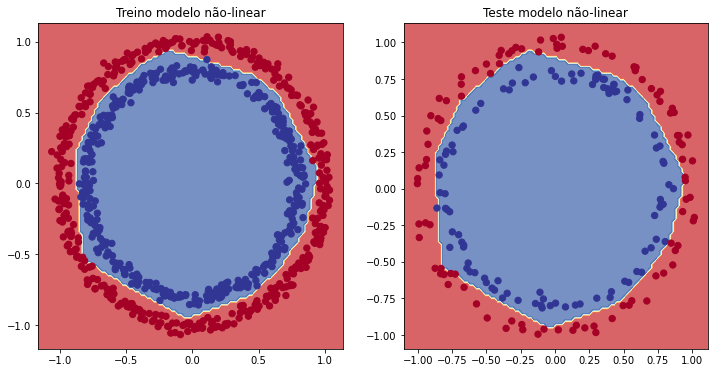

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Treino modelo não-linear")
plot_decision_boundary(model_3_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Teste modelo não-linear")
plot_decision_boundary(model_3_1, X_test, y_test)

Agora o modelo possui 99% de acurácia nos dados de teste.

## 7. Replicando funções de ativação não-lineares

Em redes neurais, ao invés de dizermos o que aprender, nós fornecemos as ferramentas para descobrir padrões nos dados e ele tenta descobrir essess padrões sozinho.

Essas ferramentas são funções lineares e não-lineares.

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

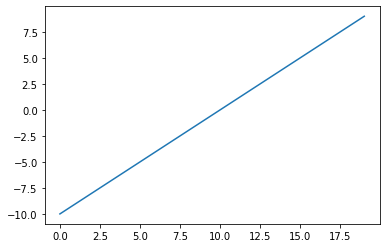

In [ ]:
plt.plot(A)

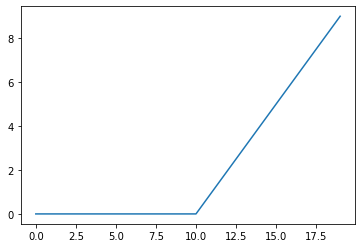

In [ ]:
# ReLU
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

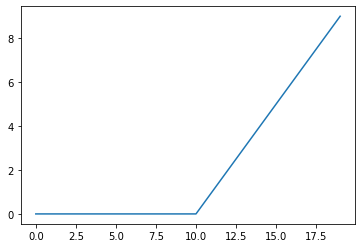

In [ ]:
plt.plot(relu(A))

In [ ]:
# Sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

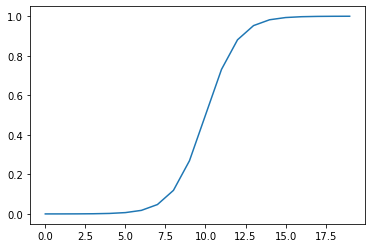

In [ ]:
plt.plot(torch.sigmoid(A))

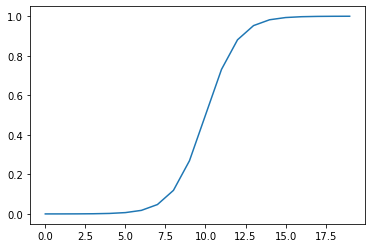

In [ ]:
plt.plot(sigmoid(A))

## 8. Juntando tudo com um problema de classificação multi-classe

* Classificação binária = uma classe ou outra (gato ou cachorro)
* Classificação Multi-classe = Mais do que uma classe ou outra (gato, cachorro ou galinha)

### 8.1 Criando um toy dataset multi-classe

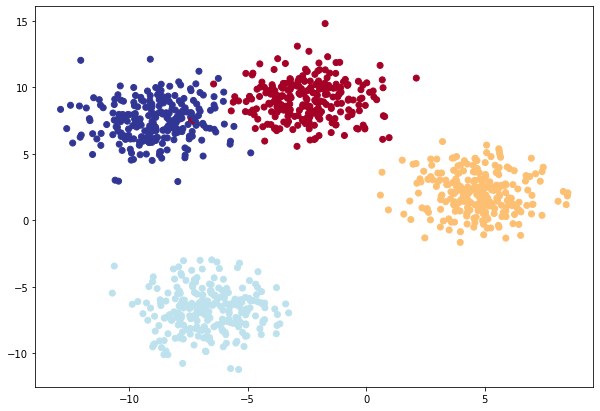

In [34]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Define os hiperparâmetros para a criação dos dados
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Criando dados multi-classe
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Transformando dados em tensores
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Dividindo em treino e teste
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

# 4. Plotando os dados
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Construindo um modelo de classificação multi-classe em PyTorch

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Inicializa o modelo de classificação multi-classe.

    Args:
      input_features (int): Número de feataures de entrada
      output_features (int): Número de classes de saída
      hidden_units (int): Número de unidades escondidas entre camadas, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Criando uma função de loss e um otimizador

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Conseguindo probabilidades de predição de um modelo PyTorch multi-classe

Para avaliar, treinar e testar o modelo, devemos converter as saídas do modelo (logits) para probabilidades de predição (`torch.softmax`) e, então, para labels (`torch.argmax`).

In [38]:
# Lembrando que as saídas puras do modelo são conhecidas como logits
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [39]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [40]:
# Convertendo os logits para probabilidades
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [41]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [42]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [43]:
len(y_blob_train)

800

## 8.5 Criando um loop de treino e de teste para o modelo

In [44]:
# Fitando o modelo aos dados
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    y_test_logits = model_4(X_blob_test)
    y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(y_test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                      y_pred=y_test_pred)
    
    if epoch % 10 == 0 or epoch == epochs - 1:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.4f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.1588, Acc: 40.3750% | Test Loss: 1.0755, Test acc: 48.00
Epoch: 10 | Loss: 0.6448, Acc: 96.7500% | Test Loss: 0.6607, Test acc: 97.50
Epoch: 20 | Loss: 0.4254, Acc: 98.5000% | Test Loss: 0.4307, Test acc: 100.00
Epoch: 30 | Loss: 0.2529, Acc: 99.1250% | Test Loss: 0.2451, Test acc: 99.50
Epoch: 40 | Loss: 0.1123, Acc: 99.2500% | Test Loss: 0.1023, Test acc: 99.50
Epoch: 50 | Loss: 0.0663, Acc: 99.2500% | Test Loss: 0.0585, Test acc: 99.50
Epoch: 60 | Loss: 0.0507, Acc: 99.2500% | Test Loss: 0.0429, Test acc: 99.50
Epoch: 70 | Loss: 0.0430, Acc: 99.2500% | Test Loss: 0.0349, Test acc: 99.50
Epoch: 80 | Loss: 0.0384, Acc: 99.2500% | Test Loss: 0.0299, Test acc: 99.50
Epoch: 90 | Loss: 0.0352, Acc: 99.2500% | Test Loss: 0.0266, Test acc: 99.50
Epoch: 99 | Loss: 0.0333, Acc: 99.2500% | Test Loss: 0.0245, Test acc: 99.50


### 8.6 Avaliando o modelo

In [46]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [50]:
# De logits para probabilidades
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [51]:
# De probabilidades para labels/classes
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

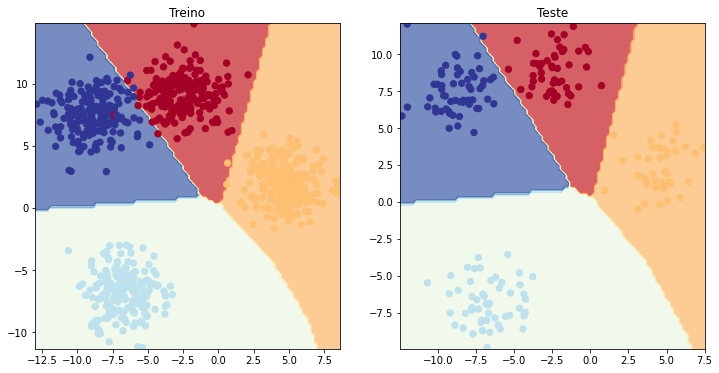

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Treino")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Teste")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Mais algumas métricas de classificação (para avaliar o modelo)

* Acurácia - De 100%, quantos o modelo consegue acertar? Bom quando as classes são balanceadas
* Precisão - Dos marcados como uma classe, quantos realmente são dessa classe? Maior precisão leva a menos falso positivos
* Revocação - Quantos de uma certa classe foram corretamente classificados como sendo daquela classe? Maior revocação leva a menos falso negativos
* F1-Score - Combina Precisão e revocação.
* Matriz de confusão - Matriz para ver as classficações
* Classification Report - Mostra um monte de métricas ao mesmo tempo

O PyTorch possui o `torchmetrics` em que é possível calcular a maioria dessas coisas.

In [53]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 13.9 MB/s eta 0:00:00


In [58]:
from torchmetrics import Accuracy

torchmetric_acc = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetric_acc(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [59]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
confmat(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')